In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely import Polygon
from shapely import MultiPolygon
import h3.api.numpy_int as h3
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr

In [2]:
import pysal as ps
import libpysal

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
import spopt

In [4]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

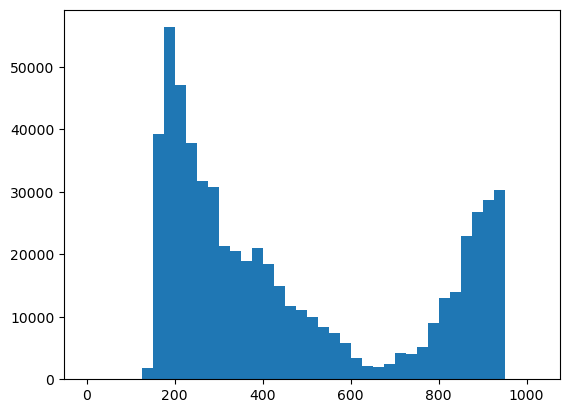

In [5]:
plt.hist(ob_pre[np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))],np.arange(0.,1026.,25.))
plt.show()

In [6]:
opt_tim=1.5 # select observations around this time (hrs) in the time-window (0==analysis-time)
opt_pre=225. # select observations around this pressure-level (hPa)
# Select subset of data from lat, lon, prs, tim: 
idx=np.where((ob_use==1.)&
             (np.abs(ob_pre-opt_pre)<25.)&
             (np.abs(ob_tim-opt_tim)<0.5)&
             (ob_typ>=240)&(ob_typ<=260)
            )[0]
print('{:d} observations in range'.format(np.size(idx)))
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in idx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
    nob_list.append(1)
d = {'geometry': point_list, 
     'lat': list(ob_lat[idx]),
     'lon': list(ob_lon[idx]),
     'pre': list(ob_pre[idx]),
     'tim': list(ob_tim[idx]),
     'uwd': list(ob_uwd[idx]),
     'vwd': list(ob_vwd[idx]),
     'nob': nob_list,
     'ob_idx': list(idx)
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")

gdfE

3058 observations in range


,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx
0,POINT (668037.174 -5115089.496),-45.949631,6.001080,248.699997,1.5,59.998913,33.257938,1,5266
1,POINT (670388.249 -5111596.324),-45.918251,6.022200,248.899994,1.5,60.881584,35.150002,1,5532
2,POINT (758405.222 -4979241.787),-44.729290,6.812870,244.100006,1.5,53.086880,44.545181,1,5536
3,POINT (729048.042 -5163292.809),-46.382648,6.549150,247.399994,1.5,64.084602,43.225613,1,5542
4,POINT (670642.031 -5108125.233),-45.887070,6.024480,245.100006,1.5,61.059464,38.154186,1,5545
...,...,...,...,...,...,...,...,...,...
3053,POINT (-421052.521 1219683.154),10.956600,-3.782379,240.600006,1.5,16.320065,13.215728,1,1839731
3054,POINT (-147951.512 1430555.610),12.850900,-1.329071,221.800003,1.5,16.845360,18.064436,1,1839734
3055,POINT (-190650.935 1628263.487),14.626940,-1.712646,213.899994,1.5,26.555962,20.747791,1,1839744
3056,POINT (-528696.240 935064.783),8.399830,-4.749359,228.000000,1.5,22.552368,9.572912,1,1839776


In [7]:
# Define weights by a DistanceBand cutoff distance around each ob
distThreshold=1000.*100. # m
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1245 disconnected components.
 There are 758 islands with ids: 7, 35, 37, 54, 61, 64, 86, 138, 144, 160, 161, 171, 202, 209, 210, 243, 255, 257, 282, 285, 299, 302, 313, 318, 320, 379, 381, 389, 391, 411, 476, 480, 486, 494, 501, 536, 537, 543, 545, 571, 606, 617, 631, 633, 663, 671, 692, 696, 705, 713, 723, 733, 734, 739, 747, 752, 755, 781, 790, 807, 846, 850, 875, 961, 1018, 1033, 1063, 1150, 1151, 1175, 1185, 1200, 1203, 1208, 1229, 1252, 1265, 1325, 1327, 1329, 1330, 1333, 1335, 1336, 1337, 1338, 1340, 1345, 1346, 1347, 1348, 1349, 1352, 1355, 1357, 1380, 1418, 1420, 1424, 1425, 1427, 1428, 1429, 1434, 1438, 1474, 1512, 1513, 1515, 1516, 1517, 1529, 1535, 1536, 1537, 1538, 1539, 1540, 1543, 1544, 1545, 1551, 1552, 1553, 1554, 1559, 1564, 1567, 1573, 1576, 1587, 1590, 1591, 1593, 1594, 1596, 1605, 1606

In [48]:
from spopt.region import MaxPHeuristic as MaxP

In [49]:
# Let's try separating islands from the rest of the dataset
gdfE_islands=gdfE.iloc[w.islands]
gdfE_islands=gdfE_islands.reset_index() # Resets index numbering to start at 0
gdfE_connect=gdfE.drop(index=w.islands)
gdfE_connect=gdfE_connect.reset_index() # Resets index numbering to start at 0
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE_connect,threshold=distThreshold) # threshold in m
gdfE_connect

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 487 disconnected components.
  warnings.warn(message)


,index,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx
0,0,POINT (668037.174 -5115089.496),-45.949631,6.001080,248.699997,1.5,59.998913,33.257938,1,5266
1,1,POINT (670388.249 -5111596.324),-45.918251,6.022200,248.899994,1.5,60.881584,35.150002,1,5532
2,2,POINT (758405.222 -4979241.787),-44.729290,6.812870,244.100006,1.5,53.086880,44.545181,1,5536
3,3,POINT (729048.042 -5163292.809),-46.382648,6.549150,247.399994,1.5,64.084602,43.225613,1,5542
4,4,POINT (670642.031 -5108125.233),-45.887070,6.024480,245.100006,1.5,61.059464,38.154186,1,5545
...,...,...,...,...,...,...,...,...,...,...
2295,3053,POINT (-421052.521 1219683.154),10.956600,-3.782379,240.600006,1.5,16.320065,13.215728,1,1839731
2296,3054,POINT (-147951.512 1430555.610),12.850900,-1.329071,221.800003,1.5,16.845360,18.064436,1,1839734
2297,3055,POINT (-190650.935 1628263.487),14.626940,-1.712646,213.899994,1.5,26.555962,20.747791,1,1839744
2298,3056,POINT (-528696.240 935064.783),8.399830,-4.749359,228.000000,1.5,22.552368,9.572912,1,1839776


In [50]:
w.islands

[]

In [51]:
attrs_name = [f"uwd" , f"vwd" , f"tim", f"pre"]
threshold_name = "nob"
threshold = 2

In [52]:
model = MaxP(gdfE_connect, w, attrs_name, threshold_name, threshold)
model.solve()

In [53]:
print('{:d} observations aggregated to {:d} clusters and {:d} islands'.format(np.size(idx),max(model.labels_),len(gdfE_islands)))

3058 observations aggregated to 1033 clusters and 758 islands


In [54]:
# Assign each polygon in cellframe_connect to a cluster
gdfE_connect['cluster']=model.labels_
# Assign each polygon in cellframe_islands to its own cluster, incrementing from max(model.labels_)
gdfE_islands['cluster']=np.arange(max(model.labels_)+1,max(model.labels_)+1+len(gdfE_islands))

In [55]:
# Append into master cellframe
gdfE=pd.concat([gdfE_connect,gdfE_islands],ignore_index=True)
gdfE

,index,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx,cluster
0,0,POINT (668037.174 -5115089.496),-45.949631,6.001080,248.699997,1.5,59.998913,33.257938,1,5266,417
1,1,POINT (670388.249 -5111596.324),-45.918251,6.022200,248.899994,1.5,60.881584,35.150002,1,5532,853
2,2,POINT (758405.222 -4979241.787),-44.729290,6.812870,244.100006,1.5,53.086880,44.545181,1,5536,331
3,3,POINT (729048.042 -5163292.809),-46.382648,6.549150,247.399994,1.5,64.084602,43.225613,1,5542,853
4,4,POINT (670642.031 -5108125.233),-45.887070,6.024480,245.100006,1.5,61.059464,38.154186,1,5545,417
...,...,...,...,...,...,...,...,...,...,...,...
3053,2965,POINT (-1469860.274 5659651.090),50.841511,-13.203979,248.300003,1.5,9.221254,21.723915,1,1817570,1787
3054,2968,POINT (-269578.111 -4852013.628),-43.586380,-2.421661,234.500000,1.5,50.940525,12.700899,1,1824620,1788
3055,2973,POINT (-678594.348 -4945213.721),-44.423611,-6.095917,211.399994,1.5,48.880638,3.418067,1,1824643,1789
3056,3017,POINT (-933744.546 502824.588),4.516950,-8.387970,246.600006,1.5,12.762876,6.224870,1,1837399,1790


In [64]:
clusmems=[]
for l in np.sort(gdfE['cluster'].unique()):
    cluster_idxs=np.where(np.asarray(gdfE['cluster'])==l)[0]
    clusmems.append(len(cluster_idxs))
n_clusters=len(gdfE['cluster'].unique())
print('{:d} clusters containing as many as {:d} obs'.format(n_clusters,max(clusmems)))

1791 clusters containing as many as 5 obs


In [66]:
np.where(np.asarray(clusmems)==max(clusmems))

(array([ 23, 587]),)

In [71]:
gdfE.loc[gdfE['cluster']==23+1]

,index,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx,cluster
2022,2676,POINT (-18490168.100 1069780.268),9.61,-166.100006,223.600006,1.166667,20.976404,-3.698706,1,589526,24
2025,2680,POINT (-18511317.377 994083.087),8.93,-166.289993,204.300003,1.166667,20.345470,-4.324563,1,589557,24
2029,2689,POINT (-18412243.098 1070893.489),9.62,-165.399994,213.899994,1.166667,21.438997,-2.632378,1,589768,24
2031,2691,POINT (-18511317.377 994083.087),8.93,-166.289993,204.300003,1.166667,20.516008,-3.987908,1,589780,24
2032,2693,POINT (-18542488.397 1143251.221),10.27,-166.570007,218.000000,1.166667,21.586842,-0.753829,1,589786,24


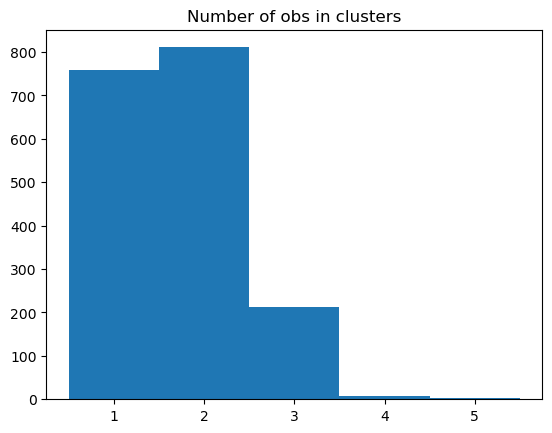

In [69]:
plt.hist(clusmems,np.arange(0.5,max(clusmems)+0.6,1.))
plt.title('Number of obs in clusters')
plt.show()